<a href="https://colab.research.google.com/github/yannmean/CS236_FinalProject/blob/main/CS236_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CS236 Project
---

Luke Carani, Kevin Hu, Yan Min

## Install packages, sort out dependencies

In [ ]:
# Install magenta
#@test {"output": "ignore"}
print('Installing dependencies...')
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi
!pip install note-seq
!pip install -qU magenta
!pip install note_seq

# Hack to allow python to pick up the newly-installed fluidsynth lib. 
# This is only needed for the hosted Colab environment.
import ctypes.util
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library

print('Importing libraries and defining some helper functions...')
import magenta
import note_seq
from note_seq.protobuf import music_pb2
import tensorflow

print('Done')

Installing dependencies...
Selecting previously unselected package fluid-soundfont-gm.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../fluid-soundfont-gm_3.1-5.1_all.deb ...
Unpacking fluid-soundfont-gm (3.1-5.1) ...
Selecting previously unselected package libfluidsynth1:amd64.
Preparing to unpack .../libfluidsynth1_1.1.9-1_amd64.deb ...
Unpacking libfluidsynth1:amd64 (1.1.9-1) ...
Setting up fluid-soundfont-gm (3.1-5.1) ...
Setting up libfluidsynth1:amd64 (1.1.9-1) ...
Processing triggers for libc-bin (2.27-3ubuntu1.3) ...
/sbin/ldconfig.real: /usr/local/lib/python3.7/dist-packages/ideep4py/lib/libmkldnn.so.0 is not a symbolic link

     |████████████████████████████████| 5.6 MB 3.6 MB/s 
     |████████████████████████████████| 51 kB 6.2 MB/s 
     |████████████████████████████████| 210 kB 4.1 MB/s 
     |████████████████████████████████| 1.4 MB 4.2 MB/s 
     |████████████████████████████████| 2.3 MB 60.2 MB/s 
     |██████████████████

/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


Done


In [ ]:
#@title Setup Environment
#@test {"output": "ignore"}

import glob

BASE_DIR = "gs://download.magenta.tensorflow.org/models/music_vae/colab2"

print('Installing dependencies...')
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -q pyfluidsynth
!pip install -qU magenta

# Hack to allow python to pick up the newly-installed fluidsynth lib.
# This is only needed for the hosted Colab environment.
import ctypes.util
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library


print('Importing libraries and defining some helper functions...')
from google.colab import files
import magenta.music as mm
from magenta.models.music_vae import configs
from magenta.models.music_vae.trained_model import TrainedModel
import numpy as np
import os
import tensorflow.compat.v1 as tf
from matplotlib import pyplot as plt

tf.disable_v2_behavior()

# Necessary until pyfluidsynth is updated (>1.2.5).
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

def play(note_sequence):
  mm.play_sequence(note_sequence, synth=mm.fluidsynth)

def interpolate(model, start_seq, end_seq, num_steps, max_length=32,
                assert_same_length=True, temperature=0.5,
                individual_duration=4.0):
  """Interpolates between a start and end sequence."""
  note_sequences = model.interpolate(
      start_seq, end_seq,num_steps=num_steps, length=max_length,
      temperature=temperature,
      assert_same_length=assert_same_length)

  print('Start Seq Reconstruction')
  play(note_sequences[0])
  print('End Seq Reconstruction')
  play(note_sequences[-1])
  print('Mean Sequence')
  play(note_sequences[num_steps // 2])
  print('Start -> End Interpolation')
  interp_seq = mm.sequences_lib.concatenate_sequences(
      note_sequences, [individual_duration] * len(note_sequences))
  play(interp_seq)
  mm.plot_sequence(interp_seq)
  return interp_seq if num_steps > 3 else note_sequences[num_steps // 2]

def download(note_sequence, filename):
  mm.sequence_proto_to_midi_file(note_sequence, filename)
  files.download(filename)

print('Done')

Installing dependencies...
Importing libraries and defining some helper functions...
Instructions for updating:
non-resource variables are not supported in the long term
Done


In [ ]:
# Mount drive, navigate to repository
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/CS236_Project/')

Mounted at /content/drive


## Generate input samples for Music VAE
We take a sample (64 sec segment) of our different Classical and Symphonic Metal MIDIs:
1. Just the original subsample (control)
2. Masked out version of the sample
3. Sparse note of the the same sample.

In [ ]:
# Take a sample, convert it to note sequence

# This is a method that imports a midi file and converts it to a note sequence
NTS_metal_1_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/notturneSpoglieMetal/notturneSpoglieMetal_1.mid')
NTS_metal_2_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/notturneSpoglieMetal/notturneSpoglieMetal_2.mid')
NTS_metal_3_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/notturneSpoglieMetal/notturneSpoglieMetal_3.mid')
NTS_classic_1_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/notturneSpoglieClassical/notturneSpoglieClassical_1.mid')
NTS_classic_2_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/notturneSpoglieClassical/notturneSpoglieClassical_2.mid')
NTS_classic_3_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/notturneSpoglieClassical/notturneSpoglieClassical_3.mid')

reqdminor_classic_1_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/requiemDMinorClassical/requiemDMinorClassical_1.mid')
reqdminor_classic_2_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/requiemDMinorClassical/requiemDMinorClassical_2.mid')
reqdminor_metal_1_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/requiemDMinorMetal/requiemDMinorMetal_1.mid')
reqdminor_metal_2_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/requiemDMinorMetal/requiemDMinorMetal_2.mid')

symph9_metal_1_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/symphonyNo9Metal/symphonyNo9Metal_1.mid')
symph9_metal_2_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/symphonyNo9Metal/symphonyNo9Metal_2.mid')
symph9_classic_1_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/symphonyNo9Classical/symphonyNo9Classical_1.mid')
symph9_classic_2_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/symphonyNo9Classical/symphonyNo9Classical_2.mid')
symph9_classic_3_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/symphonyNo9Classical/symphonyNo9Classical_3.mid')
symph9_classic_4_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/symphonyNo9Classical/symphonyNo9Classical_4.mid')
symph9_classic_5_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/symphonyNo9Classical/symphonyNo9Classical_5.mid')
symph9_classic_6_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/symphonyNo9Classical/symphonyNo9Classical_6.mid')
symph9_classic_7_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/symphonyNo9Classical/symphonyNo9Classical_7.mid')
symph9_classic_8_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/symphonyNo9Classical/symphonyNo9Classical_8.mid')
symph9_classic_9_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/symphonyNo9Classical/symphonyNo9Classical_9.mid')
symph9_classic_10_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/audioFilesForStyleComparison/symphonyNo9Classical/symphonyNo9Classical_10.mid')


In [ ]:
#@title Example visualization and playing of some of the MIDIs (skip if not needed)
###################################################################################

print(type(NTS_metal_1_noteseq))

print("Notturne Spoglie Metal")
note_seq.plot_sequence(NTS_metal_1_noteseq)                            # This is a colab utility method that visualizes a NoteSequence.
# note_seq.play_sequence(NTS_metal_1_noteseq, synth=note_seq.fluidsynth) # This is a colab utility method that plays a NoteSequence.
note_seq.plot_sequence(NTS_metal_2_noteseq)
# note_seq.play_sequence(NTS_metal_2_noteseq, synth=note_seq.fluidsynth)
note_seq.plot_sequence(NTS_metal_3_noteseq)
# note_seq.play_sequence(NTS_metal_3_noteseq, synth=note_seq.fluidsynth)
print("Notturne Spoglie Classical")
note_seq.plot_sequence(NTS_classic_1_noteseq)
# note_seq.play_sequence(NTS_classic_1_noteseq, synth=note_seq.fluidsynth)
note_seq.plot_sequence(NTS_classic_2_noteseq)
# note_seq.play_sequence(NTS_classic_2_noteseq, synth=note_seq.fluidsynth)
note_seq.plot_sequence(NTS_classic_3_noteseq)
# note_seq.play_sequence(NTS_classic_3_noteseq, synth=note_seq.fluidsynth)

print("Requiem D Minor Classical")
note_seq.plot_sequence(reqdminor_classic_1_noteseq)
# note_seq.play_sequence(reqdminor_classic_1_noteseq, synth=note_seq.fluidsynth)
note_seq.plot_sequence(reqdminor_classic_2_noteseq)
# note_seq.play_sequence(reqdminor_classic_2_noteseq, synth=note_seq.fluidsynth)
print("Requiem D Minor Metal")
note_seq.plot_sequence(reqdminor_metal_1_noteseq)
# note_seq.play_sequence(reqdminor_metal_1_noteseq, synth=note_seq.fluidsynth)
note_seq.plot_sequence(reqdminor_metal_2_noteseq)
# note_seq.play_sequence(reqdminor_metal_2_noteseq, synth=note_seq.fluidsynth)



In [ ]:
#@title code to download MIDIs (skip if not needed)

note_seq.sequence_proto_to_midi_file(bbboogie_noteseq, 'bbboogie_output.mid')
files.download('bbboogie_output.mid')

# **EXPERIMENT 1:** Latent-Space Averaging (unique melody extraction) with 2-bar Melody Model. Compare standard reconstruction to latent-space averaging reconstruction

In [ ]:
#@title Load the pre-trained model.
mel_2bar_config = configs.CONFIG_MAP['cat-mel_2bar_big']
mel_2bar = TrainedModel(mel_2bar_config, batch_size=4, checkpoint_dir_or_path=BASE_DIR + '/checkpoints/mel_2bar_big.ckpt')

In [ ]:
#@title Make a list of all NoteSequences
seqs = [NTS_classic_1_noteseq,
        NTS_classic_2_noteseq,
        NTS_classic_3_noteseq,
        reqdminor_classic_1_noteseq,
        reqdminor_classic_2_noteseq,
        symph9_classic_1_noteseq,
        symph9_classic_2_noteseq,
        symph9_classic_3_noteseq,
        symph9_classic_4_noteseq,
        symph9_classic_5_noteseq,
        symph9_classic_6_noteseq,
        symph9_classic_7_noteseq,
        symph9_classic_8_noteseq,
        symph9_classic_9_noteseq,
        symph9_classic_10_noteseq,
        NTS_metal_1_noteseq,
        NTS_metal_2_noteseq,
        NTS_metal_3_noteseq,
        reqdminor_metal_1_noteseq,
        reqdminor_metal_2_noteseq,
        symph9_metal_1_noteseq,
        symph9_metal_2_noteseq]

titles = ["NTS_classic_1_mean.mid",
"NTS_classic_2_mean.mid",
"NTS_classic_3_mean.mid",
"reqdminor_classic_1_mean.mid",
"reqdminor_classic_2_mean.mid",
"symph9_classic_1_mean.mid",
"symph9_classic_2_mean.mid",
"symph9_classic_3_mean.mid",
"symph9_classic_4_mean.mid",
"symph9_classic_5_mean.mid",
"symph9_classic_6_mean.mid",
"symph9_classic_7_mean.mid",
"symph9_classic_8_mean.mid",
"symph9_classic_9_mean.mid",
"symph9_classic_10_mean.mid",
"NTS_metal_1_mean.mid",
"NTS_metal_2_mean.mid",
"NTS_metal_3_mean.mid",
"reqdminor_metal_1_mean.mid",
"reqdminor_metal_2_mean.mid",
"symph9_metal_1_mean.mid",
"symph9_metal_2_mean.mid"]

In [ ]:
#@title Extract melodies from all MIDI files. This will extract all unique 2-bar melodies using a sliding window with a stride of 1 bar.
all_extracted_mels = []
for ns in seqs:
  extracted_mels = []
  extracted_mels.extend(
      mel_2bar_config.data_converter.from_tensors(
          mel_2bar_config.data_converter.to_tensors(ns)[1]))
  all_extracted_mels.append(extracted_mels)

print(len(all_extracted_mels))
print(type(all_extracted_mels))
print(type(all_extracted_mels[0]))

22
<class 'list'>
<class 'list'>


In [ ]:
#@title Convert extracted melodies into latent embeddings and take the mean across the melodies
latents = []  # create empty list for latents 
for mel in all_extracted_mels:
  z, _, _ = mel_2bar.encode(mel)
  # print(z.shape)
  z = z.mean(axis=0, keepdims=True)
  latents.append(z)

print(len(latents))

22


In [ ]:
#@title Convert latent space MEAN embedding back into NoteSequences, and Visualize and play the processed melodies for MEAN latent embedding
for l in range(len(latents)):
  length = latents[l].shape[-1]
  output_mean = mel_2bar.decode(latents[l], length=length)  # decode one latent embedding at a time

  # This is a colab utility method that visualizes a NoteSequence (comment out if not needed).
  note_seq.plot_sequence(output_mean[0])
  # This is a colab utility method that plays a NoteSequence (comment out if not needed).
  note_seq.play_sequence(output_mean[0], synth=note_seq.fluidsynth)

  #code to download MIDIs (comment out if not needed)
  note_seq.sequence_proto_to_midi_file(output_mean[0], titles[l])
  files.download(titles[l])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Visualize and play original NoteSequence to compare

# This is a colab utility method that visualizes a NoteSequence.
note_seq.plot_sequence(symph9_classic_10_noteseq)
# This is a colab utility method that plays a NoteSequence.
note_seq.play_sequence(NTS_classic_1_noteseq, synth=note_seq.fluidsynth)

# **EDA:** Latent-space clustering / visualization

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn import decomposition
import pandas as pd

In [ ]:
#@title Make a list of all NoteSequences
seqs = [NTS_classic_1_noteseq,
        NTS_classic_2_noteseq,
        NTS_classic_3_noteseq,
        reqdminor_classic_1_noteseq,
        reqdminor_classic_2_noteseq,
        symph9_classic_1_noteseq,
        symph9_classic_2_noteseq,
        symph9_classic_3_noteseq,
        symph9_classic_4_noteseq,
        symph9_classic_5_noteseq,
        symph9_classic_6_noteseq,
        symph9_classic_7_noteseq,
        symph9_classic_8_noteseq,
        symph9_classic_9_noteseq,
        symph9_classic_10_noteseq,
        NTS_metal_1_noteseq,
        NTS_metal_2_noteseq,
        NTS_metal_3_noteseq,
        reqdminor_metal_1_noteseq,
        reqdminor_metal_2_noteseq,
        symph9_metal_1_noteseq,
        symph9_metal_2_noteseq]

In [ ]:
#@title Extract melodies from all MIDI files. This will extract all unique 2-bar melodies using a sliding window with a stride of 1 bar.
all_extracted_mels = []
for ns in seqs:
  extracted_mels = []
  extracted_mels.extend(
      mel_2bar_config.data_converter.from_tensors(
          mel_2bar_config.data_converter.to_tensors(ns)[1]))
  all_extracted_mels.append(extracted_mels)

In [ ]:
#@title Convert extracted melodies into latent embeddings
latents = []  # create empty list for latents 
for mel in all_extracted_mels:
  z, _, _ = mel_2bar.encode(mel)
  # z = np.mean(z, axis=-1)
  latents.append(z)

print(len(latents))

22


In [ ]:
#@title Combine latent spaces by vertically stacking rows
X = np.vstack(tuple(latents))
print(X.shape)
y = np.concatenate((np.repeat(0, 75), np.repeat(1, 35)))  # 0 is classical, 1 is metal
print(y.shape)

(110, 512)
(110,)


Projecting 512-dimensional data to 2D using PCA


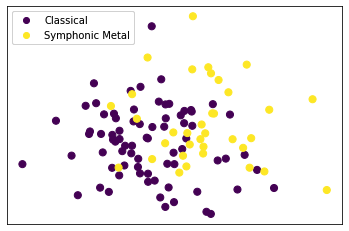

PCA explained variance ratio: [0.01939802 0.0182817 ]


<Figure size 432x288 with 0 Axes>

In [ ]:
print("Projecting %d-dimensional data to 2D using PCA" % X.shape[1])

X_bar = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_normalized = (X - X_bar) / X_std
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X_normalized)

# plot results
fig, ax = plt.subplots()
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, s=50)
# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(), loc="upper left")
legend1.get_texts()[0].set_text("Classical")
legend1.get_texts()[1].set_text("Symphonic Metal")
ax.add_artist(legend1)
# plt.title("PCA of Classical and Symphonic Metal Latent Embeddings", fontsize=18)
plt.tick_params(
    axis='both',  # changes apply to the x-axis and y-axis
    which='both',  # both major and minor ticks are affected
    labelbottom=False,  # labels along bottom edge are off
    labelleft=False,  # labels along the left edge are off
    left=False,
    bottom=False)
# plt.savefig(savepath, bbox_inches='tight')
plt.show()
plt.clf()

print("PCA explained variance ratio: " + str(pca.explained_variance_ratio_))

# **EXPERIMENT 2:** Infilling / Interpolation on Trimmed and Sparse NoteSequences with 2-bar Melody Model

In [ ]:
#@title Load the pre-trained model.
mel_2bar_config = configs.CONFIG_MAP['cat-mel_2bar_big']
mel_2bar = TrainedModel(mel_2bar_config, batch_size=4, checkpoint_dir_or_path=BASE_DIR + '/checkpoints/mel_2bar_big.ckpt')

INFO:tensorflow:Building MusicVAE model with BidirectionalLstmEncoder, CategoricalLstmDecoder, and hparams:
{'max_seq_len': 32, 'z_size': 512, 'free_bits': 0, 'max_beta': 0.5, 'beta_rate': 0.99999, 'batch_size': 4, 'grad_clip': 1.0, 'clip_mode': 'global_norm', 'grad_norm_clip_to_zero': 10000, 'learning_rate': 0.001, 'decay_rate': 0.9999, 'min_learning_rate': 1e-05, 'conditional': True, 'dec_rnn_size': [2048, 2048, 2048], 'enc_rnn_size': [2048], 'dropout_keep_prob': 1.0, 'sampling_schedule': 'inverse_sigmoid', 'sampling_rate': 1000, 'use_cudnn': False, 'residual_encoder': False, 'residual_decoder': False, 'control_preprocessing_rnn_size': [256]}
INFO:tensorflow:
Encoder Cells (bidirectional):
  units: [2048]

INFO:tensorflow:
Decoder Cells:
  units: [2048, 2048, 2048]

Instructions for updating:
Use `tf.cast` instead.


/usr/local/lib/python3.7/dist-packages/magenta/models/music_vae/lstm_utils.py:99: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  name=name),
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/magenta/contrib/rnn.py:751: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._names["W"], [input_size + self._num_units, self._num_units * 4])
/usr/local/lib/python3.7/dist-packages/magenta/contrib/rnn.py:754: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.constant_initializer(0.0))


Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Do not call `graph_parents`.


/usr/local/lib/python3.7/dist-packages/magenta/models/music_vae/base_model.py:199: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=tf.random_normal_initializer(stddev=0.001))
/usr/local/lib/python3.7/dist-packages/magenta/models/music_vae/base_model.py:205: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=tf.random_normal_initializer(stddev=0.001))


INFO:tensorflow:Restoring parameters from gs://download.magenta.tensorflow.org/models/music_vae/colab2/checkpoints/mel_2bar_big.ckpt


In [ ]:
# Simple midi (Xmas) files
deck_the_halls_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/simpleMidi/deck_the_halls.mid')
greensleeves_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/simpleMidi/greensleeves.mid')
jingle_bells_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/simpleMidi/jingle_bells.mid')
o_christmas_tree_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/simpleMidi/o_christmas_tree.mid')
wwyamc_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/simpleMidi/wwyamc.mid')
silent_night_noteseq = note_seq.midi_file_to_note_sequence('/content/drive/MyDrive/CS236_Project/simpleMidi/silent_night.mid')

In [ ]:
# Extract 2bar melodies
mel_input_seqs = [deck_the_halls_noteseq, greensleeves_noteseq, jingle_bells_noteseq, 
                  o_christmas_tree_noteseq, silent_night_noteseq, wwyamc_noteseq]
extracted_mels = []
for ns in mel_input_seqs:
  extracted_mels.extend(
      mel_2bar_config.data_converter.from_tensors(
          mel_2bar_config.data_converter.to_tensors(ns)[1]))
for i, ns in enumerate(extracted_mels):
  print("Melody", i)
  play(ns)
  output_name = None
  if i < 5:
    output_name = 'deck_the_halls_' + str(i) + '.mid'
  else:
    output_name = 'jingle_bells_' + str(i) + '.mid'
  note_seq.sequence_proto_to_midi_file(ns, output_name)
  files.download(output_name)

Melody 0


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Melody 1


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Melody 2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Melody 3


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Melody 4


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Melody 5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Melody 6


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Melody 7


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Melody 8


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Melody 9


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Visualize note seqs
# Melody 0 - 4: Deck the halls
# Melody 5 - 9: Jingle bells
for i in range(len(extracted_mels)):
  note_seq.plot_sequence(extracted_mels[i])

In [ ]:
#@title Interpolate 2 segments from Deck the Halls
start_melody = 1 #@param {type:"integer"}
end_melody = 3 #@param {type:"integer"}
start_mel = extracted_mels[start_melody]
end_mel = extracted_mels[end_melody]

print(type(extracted_mels[start_melody]))

temperature = 0.5 #@param {type:"slider", min:0.1, max:1.5, step:0.1}
num_steps = 13 #@param {type:"integer"}

mel_2bar_interp = interpolate(mel_2bar, start_mel, end_mel, num_steps=num_steps, temperature=temperature)
plot_sequence(mel_2bar_interp)
print(type(mel_2bar_interp))

<class 'note_seq.protobuf.music_pb2.NoteSequence'>
Start Seq Reconstruction


End Seq Reconstruction


Mean Sequence


Start -> End Interpolation


<class 'note_seq.protobuf.music_pb2.NoteSequence'>


In [ ]:
#@title Interpolate Deck the Halls with Jingle Bells
start_melody = 3 #@param {type:"integer"} # Deck the halls
end_melody = 9 #@param {type:"integer"} # Jingle bells
start_mel = extracted_mels[start_melody]
end_mel = extracted_mels[end_melody]

temperature = 0.4 #@param {type:"slider", min:0.1, max:1.5, step:0.1}
num_steps = 16 #@param {type:"integer"}

mel_2bar_interp = interpolate(mel_2bar, start_mel, end_mel, num_steps=num_steps, temperature=temperature)


Start Seq Reconstruction


End Seq Reconstruction


Mean Sequence


Start -> End Interpolation


In [ ]:
type(start_mel)

note_seq.protobuf.music_pb2.NoteSequence

In [ ]:
#@title Interpolate 2 segments from Jingle Bells
start_melody = 5 #@param {type:"integer"}
end_melody = 9 #@param {type:"integer"}
start_mel = extracted_mels[start_melody]
end_mel = extracted_mels[end_melody]

temperature = 0.6 #@param {type:"slider", min:0.1, max:1.5, step:0.1}
num_steps = 12 #@param {type:"integer"}

note_seq.plot_sequence(start_mel)
note_seq.plot_sequence(end_mel)

mel_2bar_interp = interpolate(mel_2bar, start_mel, end_mel, num_steps=num_steps, temperature=temperature)

Start Seq Reconstruction


End Seq Reconstruction


Mean Sequence


Start -> End Interpolation


In [ ]:
#@title Trimmed Melodies
time_to_begin_mask = 1.5  # seconds (float value)
time_to_end_mask = 2.5  # seconds (float value)

# Deck the halls trimmed melodies
dth_trim_list = []
for i in range(0, 5):
  print("Deck the Halls Melody", i)
  dth_noteseq_trim = music_pb2.NoteSequence() # deck the halls
  for note in extracted_mels[i].notes:
    if note.start_time < time_to_begin_mask or note.start_time > time_to_end_mask:
      dth_noteseq_trim.notes.append(note)
  note_seq.plot_sequence(dth_noteseq_trim)
  note_seq.play_sequence(dth_noteseq_trim,synth=note_seq.fluidsynth)
  print(type(dth_noteseq_trim))
  dth_trim_list.append(dth_noteseq_trim)

# Jingle Bells trimmed melodies
jgb_trim_list = []
for i in range(5, 10):
  print("Jingle Bells Melody", i)
  jgb_noteseq_trim = music_pb2.NoteSequence() # jingle bells
  for note in extracted_mels[i].notes:
    if note.start_time < time_to_begin_mask or note.start_time > time_to_end_mask:
      jgb_noteseq_trim.notes.append(note)
  note_seq.plot_sequence(jgb_noteseq_trim)
  note_seq.play_sequence(jgb_noteseq_trim,synth=note_seq.fluidsynth)
  jgb_trim_list.append(jgb_noteseq_trim)


Deck the Halls Melody 0


<class 'note_seq.protobuf.music_pb2.NoteSequence'>
Deck the Halls Melody 1


<class 'note_seq.protobuf.music_pb2.NoteSequence'>
Deck the Halls Melody 2


<class 'note_seq.protobuf.music_pb2.NoteSequence'>
Deck the Halls Melody 3


<class 'note_seq.protobuf.music_pb2.NoteSequence'>
Deck the Halls Melody 4


<class 'note_seq.protobuf.music_pb2.NoteSequence'>
Jingle Bells Melody 5


Jingle Bells Melody 6


Jingle Bells Melody 7


Jingle Bells Melody 8


Jingle Bells Melody 9


In [ ]:
def trim(ns):
  time_to_begin_mask = 1.25  # seconds (float value)
  time_to_end_mask = 2.75  # seconds (float value)
  ns_trim = music_pb2.NoteSequence()
  ns_trim.CopyFrom(ns)
  del ns_trim.notes[:]
  for note in ns.notes:
    if note.start_time >= time_to_begin_mask and note.end_time <= time_to_end_mask:
      continue
    new_note = ns_trim.notes.add()
    new_note.CopyFrom(note)
    if note.start_time > time_to_begin_mask and note.start_time < time_to_end_mask:
      new_note.start_time = time_to_end_mask
    elif note.end_time > time_to_begin_mask and note.end_time < time_to_end_mask:
      new_note.end_time = time_to_begin_mask
    else:
      new_note.end_time = note.end_time

  note_seq.plot_sequence(ns_trim)
  note_seq.play_sequence(ns_trim,synth=note_seq.fluidsynth)
  return ns_trim

trim(extracted_mels[1])

ticks_per_quarter: 220
tempos {
  qpm: 120.0
}
notes {
  pitch: 69
  velocity: 80
  end_time: 0.25
}
notes {
  pitch: 71
  velocity: 80
  start_time: 0.25
  end_time: 0.5
}
notes {
  pitch: 72
  velocity: 80
  start_time: 0.5
  end_time: 0.75
}
notes {
  pitch: 69
  velocity: 80
  start_time: 0.75
  end_time: 1.0
}
notes {
  pitch: 71
  velocity: 80
  start_time: 1.0
  end_time: 1.25
}
notes {
  pitch: 66
  velocity: 80
  start_time: 2.75
  end_time: 3.0
}
notes {
  pitch: 67
  velocity: 80
  start_time: 3.0
  end_time: 3.875
}
total_time: 3.875

In [ ]:
#@title Trimmed Melodies Interpolation
# Use 0 - 4 for start/end melody
start_melody = 2 #@param {type:"integer"}
end_melody = 4 #@param {type:"integer"}
start_mel = trim(extracted_mels[start_melody])
end_mel = trim(extracted_mels[end_melody])

temperature = 0.5 #@param {type:"slider", min:0.1, max:1.5, step:0.1}
num_steps = 13 #@param {type:"integer"}

mel_2bar_interp = interpolate(mel_2bar, start_mel, end_mel, num_steps=num_steps, temperature=temperature)

Start Seq Reconstruction


End Seq Reconstruction


Mean Sequence


Start -> End Interpolation


In [ ]:
#@ Randomly masked

In [ ]:
# Create a masked version of the same sample

time_to_begin_mask = 20.0  # seconds (float value)
time_to_end_mask = 40.0  # seconds (float value)

reqdminor_classic_1_noteseq_trim = music_pb2.NoteSequence()
reqdminor_classic_2_noteseq_trim = music_pb2.NoteSequence()
reqdminor_metal_1_noteseq_trim = music_pb2.NoteSequence()
reqdminor_metal_2_noteseq_trim = music_pb2.NoteSequence()

# reqdminor_classic_1_noteseq
print("Requiem D Minor Classical")
for note in reqdminor_classic_1_noteseq.notes:
  if note.start_time < time_to_begin_mask or note.start_time > time_to_end_mask:
    reqdminor_classic_1_noteseq_trim.notes.append(note)
note_seq.plot_sequence(reqdminor_classic_1_noteseq_trim)
note_seq.play_sequence(reqdminor_classic_1_noteseq_trim,synth=note_seq.fluidsynth)

# reqdminor_classic_2_noteseq
for note in reqdminor_classic_2_noteseq.notes:
  if note.start_time < time_to_begin_mask or note.start_time > time_to_end_mask:
    reqdminor_classic_2_noteseq_trim.notes.append(note)
note_seq.plot_sequence(reqdminor_classic_2_noteseq_trim)
note_seq.play_sequence(reqdminor_classic_2_noteseq_trim,synth=note_seq.fluidsynth)

print("Requiem D Minor Metal")
# reqdminor_metal_1_noteseq
for note in reqdminor_metal_1_noteseq.notes:
  if note.start_time < time_to_begin_mask or note.start_time > time_to_end_mask:
    reqdminor_metal_1_noteseq_trim.notes.append(note)
note_seq.plot_sequence(reqdminor_metal_1_noteseq_trim)
note_seq.play_sequence(reqdminor_metal_1_noteseq_trim,synth=note_seq.fluidsynth)

# reqdminor_metal_2_noteseq
for note in reqdminor_metal_2_noteseq.notes:
  if note.start_time < time_to_begin_mask or note.start_time > time_to_end_mask:
    reqdminor_metal_2_noteseq_trim.notes.append(note)
note_seq.plot_sequence(reqdminor_metal_2_noteseq_trim)
note_seq.play_sequence(reqdminor_metal_2_noteseq_trim,synth=note_seq.fluidsynth)


Requiem D Minor Classical


Requiem D Minor Metal


In [ ]:
note_seq.sequence_proto_to_midi_file(bbboogie_noteseq_trim, 'bbboogie_trim_output.mid')
files.download('bbboogie_trim_output.mid')

In [ ]:
# Create a sparse note version of the same sample

time_to_begin_mask_ls = [5.0, 7.0, 9.0, 11.0, 13.0, 15.0, 17.0]  # seconds (float value)

bbboogie_noteseq_sparse = music_pb2.NoteSequence()

for note in bbboogie_noteseq.notes:
  for i in range(len(time_to_begin_mask_ls)):
    if note.start_time == time_to_begin_mask_ls[i]:
      bbboogie_noteseq_sparse.notes.append(note)

note_seq.plot_sequence(bbboogie_noteseq_sparse)

note_seq.play_sequence(bbboogie_noteseq_sparse,synth=note_seq.fluidsynth)

In [ ]:
note_seq.sequence_proto_to_midi_file(bbboogie_noteseq_sparse, 'bbboogie_sparse_output.mid')
files.download('bbboogie_sparse_output.mid')

In [ ]:
#@title Load the pre-trained 16-bar hier melody models. This is a place holder for the trio model we will be using
mel_16bar_models = {}
hierdec_mel_16bar_config = configs.CONFIG_MAP['hierdec-mel_16bar']
mel_16bar_models['hierdec_mel_16bar'] = TrainedModel(hierdec_mel_16bar_config, batch_size=4, checkpoint_dir_or_path=BASE_DIR + '/checkpoints/mel_16bar_hierdec.ckpt')

INFO:tensorflow:Building MusicVAE model with BidirectionalLstmEncoder, HierarchicalLstmDecoder, and hparams:
{'max_seq_len': 256, 'z_size': 512, 'free_bits': 256, 'max_beta': 0.2, 'beta_rate': 0.0, 'batch_size': 4, 'grad_clip': 1.0, 'clip_mode': 'global_norm', 'grad_norm_clip_to_zero': 10000, 'learning_rate': 0.001, 'decay_rate': 0.9999, 'min_learning_rate': 1e-05, 'conditional': True, 'dec_rnn_size': [1024, 1024], 'enc_rnn_size': [2048, 2048], 'dropout_keep_prob': 1.0, 'sampling_schedule': 'constant', 'sampling_rate': 0.0, 'use_cudnn': False, 'residual_encoder': False, 'residual_decoder': False, 'control_preprocessing_rnn_size': [256]}
INFO:tensorflow:
Encoder Cells (bidirectional):
  units: [2048, 2048]

INFO:tensorflow:
Hierarchical Decoder:
  input length: 256
  level output lengths: [16, 16]

INFO:tensorflow:
Decoder Cells:
  units: [1024, 1024]



/usr/local/lib/python3.7/dist-packages/magenta/models/music_vae/lstm_utils.py:99: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  name=name),
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/magenta/contrib/rnn.py:751: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._names["W"], [input_size + self._num_units, self._num_units * 4])
/usr/local/lib/python3.7/dist-packages/magenta/contrib/rnn.py:754: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.constant_initializer(0.0))


INFO:tensorflow:Restoring parameters from gs://download.magenta.tensorflow.org/models/music_vae/colab2/checkpoints/mel_16bar_hierdec.ckpt


/usr/local/lib/python3.7/dist-packages/magenta/models/music_vae/base_model.py:199: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=tf.random_normal_initializer(stddev=0.001))
/usr/local/lib/python3.7/dist-packages/magenta/models/music_vae/base_model.py:205: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=tf.random_normal_initializer(stddev=0.001))


In [ ]:
#@title Upload the MIDI files
input_mel_16_midi_data1 = files.upload().values() # the metal
input_mel_16_midi_data2 = files.upload().values() # the classifcal

Saving requiemDMinorMetal_1.mid to requiemDMinorMetal_1 (3).mid


Saving requiemDMinorClassical_1.mid to requiemDMinorClassical_1 (3).mid


In [ ]:
#@title Extract melodies from MIDI files. This will extract all unique 16-bar melodies using a sliding window with a stride of 1 bar.
mel_input_seqs1 = [mm.midi_to_sequence_proto(m) for m in input_mel_16_midi_data1]
extracted_16_mels1 = []
for ns in mel_input_seqs1:
  extracted_16_mels1.extend(
      hierdec_mel_16bar_config.data_converter.from_tensors(
          hierdec_mel_16bar_config.data_converter.to_tensors(ns)[1]))
for i, ns in enumerate(extracted_16_mels1):
  print("Melody", i)
  play(ns)

Melody 0


Melody 1


Melody 2


Melody 3


Melody 4


In [ ]:
#@title Extract melodies from MIDI files. This will extract all unique 16-bar melodies using a sliding window with a stride of 1 bar.
mel_input_seqs2 = [mm.midi_to_sequence_proto(m) for m in input_mel_16_midi_data2]
extracted_16_mels2 = []
for ns in mel_input_seqs1:
  extracted_16_mels2.extend(
      hierdec_mel_16bar_config.data_converter.from_tensors(
          hierdec_mel_16bar_config.data_converter.to_tensors(ns)[1]))
for i, ns in enumerate(extracted_16_mels2):
  print("Melody", i)
  play(ns)

Melody 0


Melody 1


Melody 2


Melody 3


Melody 4


In [ ]:
#@title Convert extracted melodies into latent embeddings
z, mu, sigma = mel_16bar_models.encode(extracted_mels)
print(z.shape, type(z))
print(mu.shape, type(mu))
print(sigma.shape, type(sigma))

AttributeError: ignored

In [ ]:
#@title Load the pre-trained 16 bar, hierarchical trio models.
hierdec_trio_16bar_config = configs.CONFIG_MAP['hierdec-trio_16bar']
hierdec_trio_16bar = TrainedModel(hierdec_trio_16bar_config, batch_size=4, checkpoint_dir_or_path=BASE_DIR + '/checkpoints/trio_16bar_hierdec.ckpt')



In [ ]:
#@title Upload the MIDI files
input_trio_midi_data1 = files.upload().values()
input_trio_midi_data2 = files.upload().values()

In [ ]:
#@title Extract trios from MIDI files. This will extract all unique 16-bar trios using a sliding window with a stride of 1 bar.
trio_input_seqs = [mm.midi_to_sequence_proto(m) for m in input_trio_midi_data1]
extracted_trios = []
for ns in trio_input_seqs:
  extracted_trios.extend(
      hierdec_trio_16bar_config.data_converter.from_tensors(
          hierdec_trio_16bar_config.data_converter.to_tensors(ns)[1]))
for i, ns in enumerate(extracted_trios):
  print("Trio", i)
  play(ns)

In [ ]:
extracted_trios

[]

In [ ]:
#@title Convert midi/NoteSequence into latent embedding

z1, mu1, sigma1 = hierdec_trio_16bar.encode(extracted_trios)
print(z1.shape, type(z1))
print(mu1.shape, type(mu1))
print(sigma1.shape, type(sigma1))

# z2, mu2, sigma2 = hierdec_trio_16bar.encode(extracted_mels2)
# print(z2.shape, type(z2))
# print(mu2.shape, type(mu2))
# print(sigma2.shape, type(sigma2))

ValueError: ignored

# ***Bonus Code to Reference***

# **EXPERIMENT 3:** Latent Space Manipulation; Attribute Vector Arithmetic on latent embeddings of NoteSequences with 16-bar Hierarchical Trio Model

In [ ]:
#@title Load the pre-trained 16-bar hier melody models. This is a place holder for the trio model we will be using
hierdec_mel_16bar_config = configs.CONFIG_MAP['hierdec-mel_16bar']
mel_16bar_model = TrainedModel(hierdec_mel_16bar_config, batch_size=4, checkpoint_dir_or_path=BASE_DIR + '/checkpoints/mel_16bar_hierdec.ckpt')

In [ ]:
#@title Upload the MIDI files
input_mel_16_midi_data1 = files.upload().values() # the metal
input_mel_16_midi_data2 = files.upload().values() # the classifcal

Saving symphonyNo9Metal_1.mid to symphonyNo9Metal_1 (3).mid


Saving symphonyNo9Classical_1.mid to symphonyNo9Classical_1 (3).mid


In [ ]:
#@title Extract melodies from MIDI files. This will extract all unique 16-bar melodies using a sliding window with a stride of 1 bar.
mel_input_seqs1 = [mm.midi_to_sequence_proto(m) for m in input_mel_16_midi_data1]
extracted_16_mels1 = []
for ns in mel_input_seqs1:
  extracted_16_mels1.extend(
      hierdec_mel_16bar_config.data_converter.from_tensors(
          hierdec_mel_16bar_config.data_converter.to_tensors(ns)[1]))
for i, ns in enumerate(extracted_16_mels1):
  print("Melody", i)
  play(ns)

Melody 0


Melody 1


Melody 2


Melody 3


Melody 4


In [ ]:
#@title Extract melodies from MIDI files. This will extract all unique 16-bar melodies using a sliding window with a stride of 1 bar.
mel_input_seqs2 = [mm.midi_to_sequence_proto(m) for m in input_mel_16_midi_data2]
extracted_16_mels2 = []
for ns in mel_input_seqs1:
  extracted_16_mels2.extend(
      hierdec_mel_16bar_config.data_converter.from_tensors(
          hierdec_mel_16bar_config.data_converter.to_tensors(ns)[1]))
for i, ns in enumerate(extracted_16_mels2):
  print("Melody", i)
  play(ns)

Melody 0


Melody 1


Melody 2


Melody 3


Melody 4


In [ ]:
#@title Convert extracted metal melodies into latent embeddings
z1, mu1, sigma1 = mel_16bar_model.encode(extracted_16_mels1)

In [ ]:
print(z1.shape, type(z1))
print(mu1.shape, type(mu1))
print(sigma1.shape, type(sigma1))

(5, 512) <class 'numpy.ndarray'>
(5, 512) <class 'numpy.ndarray'>
(5, 512) <class 'numpy.ndarray'>


In [ ]:
#@title Convert extracted classical melodies into latent embeddings
z2, mu2, sigma2 = mel_16bar_model.encode(extracted_16_mels2)

In [ ]:
print(z2.shape, type(z2))
print(mu2.shape, type(mu2))
print(sigma2.shape, type(sigma2))

(5, 512) <class 'numpy.ndarray'>
(5, 512) <class 'numpy.ndarray'>
(5, 512) <class 'numpy.ndarray'>


### **EXPERIMENT 3.1:** Hypthesize an additive latent space, such that symphonic metal = metal + symphony. Hence use z_metal - z_symphony

In [ ]:
z12 = z1 - z2
z12_average = z12.mean(axis=0, keepdims=True)

In [ ]:
#@title Convert latent space additive embedding back into NoteSequences
length = z12_average.shape[-1]
output_z12 = mel_16bar_model.decode(z12_average, length=length)

In [ ]:
#@title Visualize and play the processed melodies for additive latent embedding
for i in range(len(output_z12)):
  # This is a colab utility method that visualizes a NoteSequence.
  note_seq.plot_sequence(output_z12[i])
  # This is a colab utility method that plays a NoteSequence.
  note_seq.play_sequence(output_z12[i], synth=note_seq.fluidsynth)

In [ ]:
download(output_z12[0], '%s_additive.mid' % mel_16bar_model)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#@title Visualize and play original metal NoteSequence to compare

# This is a colab utility method that visualizes a NoteSequence.
note_seq.plot_sequence(symph9_metal_1_noteseq)
# This is a colab utility method that plays a NoteSequence.
note_seq.play_sequence(symph9_metal_1_noteseq, synth=note_seq.fluidsynth)

In [ ]:
#@title Visualize and play original metal NoteSequence to compare

# This is a colab utility method that visualizes a NoteSequence.
note_seq.plot_sequence(symph9_classic_1_noteseq)
# This is a colab utility method that plays a NoteSequence.
note_seq.play_sequence(symph9_classic_1_noteseq, synth=note_seq.fluidsynth)

### **EXPERIMENT 3.2:** Hypthesize a multiplicative latent space, such that symphonic metal = metal * symphony. Hence use z_metal / z_symphony

In [ ]:
z12_mul = z1 / z2
z12_mul_average = z12_mul.mean(axis=0, keepdims=True)

In [ ]:
#@title Convert latent space additive embedding back into NoteSequences
length = z12_mul_average.shape[-1]
output_z12_mul = mel_16bar_model.decode(z12_mul_average, length=length)

In [ ]:
#@title Visualize and play the processed melodies for additive latent embedding
for i in range(len(output_z12_mul)):
  # This is a colab utility method that visualizes a NoteSequence.
  note_seq.plot_sequence(output_z12_mul[i])
  # This is a colab utility method that plays a NoteSequence.
  note_seq.play_sequence(output_z12_mul[i], synth=note_seq.fluidsynth)

In [ ]:
download(output_z12_mul[0], '%s_mul.mid' % mel_16bar_model)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### **EXPERIMENT 3.3:** Hypthesize a highly nonlinear relationship between the two latent spaces. Coming up soon.

### **The following should be the codes for the trio model**: currently not running

In [ ]:
#@title Load the pre-trained 16 bar, hierarchical trio models.
hierdec_trio_16bar_config = configs.CONFIG_MAP['hierdec-trio_16bar']
hierdec_trio_16bar = TrainedModel(hierdec_trio_16bar_config, batch_size=4, checkpoint_dir_or_path=BASE_DIR + '/checkpoints/trio_16bar_hierdec.ckpt')



In [ ]:
#@title Upload the MIDI files
input_trio_midi_data1 = files.upload().values()
input_trio_midi_data2 = files.upload().values()

In [ ]:
#@title Extract trios from MIDI files. This will extract all unique 16-bar trios using a sliding window with a stride of 1 bar.
trio_input_seqs = [mm.midi_to_sequence_proto(m) for m in input_trio_midi_data1]
extracted_trios = []
for ns in trio_input_seqs:
  extracted_trios.extend(
      hierdec_trio_16bar_config.data_converter.from_tensors(
          hierdec_trio_16bar_config.data_converter.to_tensors(ns)[1]))
for i, ns in enumerate(extracted_trios):
  print("Trio", i)
  play(ns)

In [ ]:
extracted_trios

[]

In [ ]:
#@title Convert midi/NoteSequence into latent embedding

z1, mu1, sigma1 = hierdec_trio_16bar.encode(extracted_trios)
print(z1.shape, type(z1))
print(mu1.shape, type(mu1))
print(sigma1.shape, type(sigma1))

# z2, mu2, sigma2 = hierdec_trio_16bar.encode(extracted_mels2)
# print(z2.shape, type(z2))
# print(mu2.shape, type(mu2))
# print(sigma2.shape, type(sigma2))

ValueError: ignored

In [ ]:
#@title Load the pre-trained model.
mel_2bar_config = configs.CONFIG_MAP['cat-mel_2bar_big']
mel_2bar = TrainedModel(mel_2bar_config, batch_size=4, checkpoint_dir_or_path=BASE_DIR + '/checkpoints/mel_2bar_big.ckpt')

#### First test on the original sample

In [ ]:
#@title Upload the original sample (bbboogie_output.midi from our BBKing folder) The API here seems only allow us to upload locally. So please download the samples from our google drive folder.)
input_mel_midi_data = files.upload().values()

Saving bbboogie_output.midi to bbboogie_output (3).midi


In [ ]:
#@title Extract melodies from MIDI files. This will extract all unique 2-bar melodies using a sliding window with a stride of 1 bar.
mel_input_seqs = [mm.midi_to_sequence_proto(m) for m in input_mel_midi_data]
extracted_mels = []
for ns in mel_input_seqs:
  extracted_mels.extend(
      mel_2bar_config.data_converter.from_tensors(
          mel_2bar_config.data_converter.to_tensors(ns)[1]))
for i, ns in enumerate(extracted_mels):
  print("Melody", i)
  play(ns)

Melody 0


Melody 1


Melody 2


Melody 3


Melody 4


In [ ]:
#@title Convert midi/NoteSequence into latent embedding

z, mu, sigma = mel_2bar.encode(extracted_mels)
print(z.shape, type(z))
print(mu.shape, type(mu))
print(sigma.shape, type(sigma))

(5, 512) <class 'numpy.ndarray'>
(5, 512) <class 'numpy.ndarray'>
(5, 512) <class 'numpy.ndarray'>


In [ ]:
print(z[0,:])
print(mu[0,:])

(array([  3.,  13.,  26.,  53., 121., 115., 100.,  46.,  26.,   9.]),
 array([-3.09868   , -2.5182378 , -1.9377956 , -1.3573533 , -0.77691114,
        -0.19646895,  0.38397327,  0.9644155 ,  1.5448577 ,  2.1253    ,
         2.7057421 ], dtype=float32),
 <a list of 10 Patch objects>)

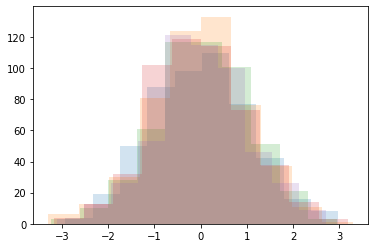

In [ ]:
#@ Visualize each latent space. It seems each latent variable follows a 
plt.hist(z[0,:], alpha = 0.2)
plt.hist(z[1,:], alpha = 0.2)
plt.hist(z[2,:], alpha = 0.2)
plt.hist(z[3,:], alpha = 0.2)
plt.hist(z[4,:], alpha = 0.2)

In [ ]:
#@title Compute latent space MEAN of the extracted melodies
z_average = z.mean(axis=0, keepdims=True)

print(z_average.shape)

In [ ]:
print(z_average.shape)
type(z_average)

(1, 512)


numpy.ndarray

(array([  2.,   6.,  12.,  40.,  97., 140., 125.,  68.,  17.,   5.]),
 array([-1.8081974 , -1.4883244 , -1.1684514 , -0.8485785 , -0.52870554,
        -0.20883256,  0.1110404 ,  0.43091336,  0.7507863 ,  1.0706593 ,
         1.3905323 ], dtype=float32),
 <a list of 10 Patch objects>)

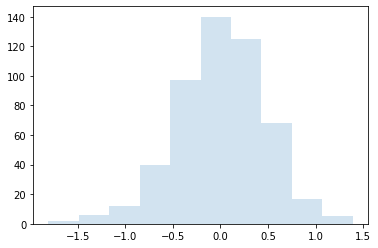

In [ ]:
plt.hist(z_average[0,:], alpha = 0.2)

In [ ]:
#@title Convert all latent embeddings back into NoteSequences
length = z.shape[-1]
outputs_all = mel_2bar.decode(z, length=length)

In [ ]:
#@title Convert latent space MEAN embedding back into NoteSequences
length = z_average.shape[-1]
output_mean = mel_2bar.decode(z_average, length=length)

In [ ]:
#@title Visualize the processed melodies for all latent embeddings
for i in range(len(outputs_all)):
  note_seq.plot_sequence(outputs_all[i])

In [ ]:
#@title Visualize and play the processed melodies for MEAN latent embedding
for i in range(len(output_mean)):
  # This is a colab utility method that visualizes a NoteSequence.
  note_seq.plot_sequence(output_mean[i])
  # This is a colab utility method that plays a NoteSequence.
  note_seq.play_sequence(output_mean[i], synth=note_seq.fluidsynth)


In [ ]:
# Visualize the extracted melodies. (Question for the team, does this represent the latent space? - No, it does not.)
for i in range(len(extracted_mels)):
  note_seq.plot_sequence(extracted_mels[i])

In [ ]:
#@title Interpolate between 2 melodies, selected from those in the previous cell.
start_melody = 0 #@param {type:"integer"}
end_melody = 3 #@param {type:"integer"}
start_mel = extracted_mels[start_melody]
end_mel = extracted_mels[end_melody]

temperature = 0.5 #@param {type:"slider", min:0.1, max:1.5, step:0.1}
num_steps = 13 #@param {type:"integer"}

mel_2bar_interp = interpolate(mel_2bar, start_mel, end_mel, num_steps=num_steps, temperature=temperature)

Start Seq Reconstruction


End Seq Reconstruction


Mean Sequence


Start -> End Interpolation


#### Now test on the trimmed sample

In [ ]:
#@title Upload the trimmed sample (bbboogie_trim_output.midi from our BBKing folder)
input_mel_midi_data = files.upload().values()

Saving bbboogie_trim_output.midi to bbboogie_trim_output (3).midi


In [ ]:
#@title Extract melodies from MIDI files. This will extract all unique 2-bar melodies using a sliding window with a stride of 1 bar.
mel_input_seqs = [mm.midi_to_sequence_proto(m) for m in input_mel_midi_data]
extracted_mels = []
for ns in mel_input_seqs:
  extracted_mels.extend(
      mel_2bar_config.data_converter.from_tensors(
          mel_2bar_config.data_converter.to_tensors(ns)[1]))
for i, ns in enumerate(extracted_mels):
  print("Melody", i)
  play(ns)

Melody 0


Melody 1


Melody 2


Melody 3


In [ ]:
# Visualize the extracted melodies.
for i in range(len(extracted_mels)):
  note_seq.plot_sequence(extracted_mels[i])

In [ ]:
#@title Interpolate between 2 melodies, selected from those in the previous cell.
start_melody = 0 #@param {type:"integer"}
end_melody = 2 #@param {type:"integer"}
start_mel = extracted_mels[start_melody]
end_mel = extracted_mels[end_melody]

temperature = 0.5 #@param {type:"slider", min:0.1, max:1.5, step:0.1}
num_steps = 13 #@param {type:"integer"}

mel_2bar_interp = interpolate(mel_2bar, start_mel, end_mel, num_steps=num_steps, temperature=temperature)

Start Seq Reconstruction


End Seq Reconstruction


Mean Sequence


Start -> End Interpolation


#### Finally test on the sparse sample

In [ ]:
#@title Upload the sparse sample (bbboogie_sparse_output.midi from our BBKing folder)
input_mel_midi_data = files.upload().values()

Saving bbboogie_sparse_output.midi to bbboogie_sparse_output (2).midi


In [ ]:
#@title Extract melodies from MIDI files. This will extract all unique 2-bar melodies using a sliding window with a stride of 1 bar.
mel_input_seqs = [mm.midi_to_sequence_proto(m) for m in input_mel_midi_data]
extracted_mels = []
for ns in mel_input_seqs:
  extracted_mels.extend(
      mel_2bar_config.data_converter.from_tensors(
          mel_2bar_config.data_converter.to_tensors(ns)[1]))
for i, ns in enumerate(extracted_mels):
  print("Melody", i)
  play(ns)

Melody 0


Melody 1


Melody 2


Melody 3


Melody 4


In [ ]:
# Visualize the extracted melodies.
for i in range(len(extracted_mels)):
  note_seq.plot_sequence(extracted_mels[i])

In [ ]:
#@title Interpolate between 2 melodies, selected from those in the previous cell.
start_melody = 0 #@param {type:"integer"}
end_melody = 1 #@param {type:"integer"}
start_mel = extracted_mels[start_melody]
end_mel = extracted_mels[end_melody]

temperature = 1.1 #@param {type:"slider", min:0.1, max:1.5, step:0.1}
num_steps = 13 #@param {type:"integer"}

mel_2bar_interp = interpolate(mel_2bar, start_mel, end_mel, num_steps=num_steps, temperature=temperature)

Start Seq Reconstruction


End Seq Reconstruction


Mean Sequence


Start -> End Interpolation


### Qualitative evaluation

Comparing the three samples, the first two, original sample & trimmed sample, yields very similar interpolation and final reconstruction. This is intuitive as it the trimmed sample still somewhat resembles the original melody. This can be seen by comparing the latent spaces of the two samples as well. (Extracted melodies)

However, the sparse sample completely loses its resemblance of the original melody. The latent space is even sparser. The reconstruction is quite monotonic and dull. This could be due to the fact that the samples of the notes are taken following a fixed time interval, which resonates with the periodical nature of the original melody. Shall try random time intervals to select the sparse sample. 

Intuitively, the controlled music generation may not work well when the sample is too sparse. It may work better with samples including a variety of melodies. However, that being said, adding the diffusion model in between the encoder and decoder could potentially change the observation above. 

## Diffusion Model

In [ ]:
# Dependencies
!pip install flax

     |████████████████████████████████| 207 kB 3.8 MB/s 
     |████████████████████████████████| 126 kB 47.7 MB/s 
     |████████████████████████████████| 65 kB 2.6 MB/s 


In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot open directory '.': Transport endpoint is not connected


In [ ]:
# Go to symbolic diffusion model git repo directory
#%cd drive/My Drive/CS236_Project/symbolic-music-diffusion
os.chdir('/content/drive/MyDrive/CS236_Project/symbolic-music-diffusion')

# Convert midis to tfrecord files

In [ ]:
! python convert_dir_to_note_sequences.py \
  --input_dir=data/Jackson_5 \
  --output_file=preprocess/j5.tfrecord \
  --recursive

In [ ]:
!pip install apache_beam

# Encode tfrecord files with MusicVAE

In [ ]:
! python scripts/generate_song_data_beam.py \
  --checkpoint=checkpoints/cat-mel_2bar_big.tar \
  --input=preprocess/j5.tfrecord \
  --output=preprocess/j5_data/training_seqs.tfrecord

# Process latent encodings before running through diffusion model
outputs tfrecord by default, can also output pickle file

In [ ]:
! python scripts/transform_encoded_data.py \
  --encoded_data=preprocess/j5_data \
  --output_path=preprocess/j5_transformed \
  --mode=sequences \
  --context_length=32 \
  --output_format=pkl


2021-11-22 21:32:07.536885: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
I1122 21:32:07.872097 140565022730112 transform_encoded_data.py:256] Discarded 0 invalid sequences.
I1122 21:32:07.936670 140565022730112 transform_encoded_data.py:104] Saved to preprocess/j5_transformed/train-0000.tfrecord
I1122 21:32:07.958622 140565022730112 transform_encoded_data.py:256] Discarded 0 invalid sequences.


In [ ]:
! pip install ray

# Sampling and Generation (running through diffusion model)
Required input: tfrecord_data/train-* and tfrecord_data/eval-*

Outputs real, generated, and collection pickle files

In [ ]:
! python sample_ncsn.py \
  --flagfile=configs/test-small.cfg \
  --sample_seed=42 \
  --sample_size=10 \
  --sampling_dir=samples/kevin

/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.7/dist-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/usr/local/lib/python3.7/dist-packages/jax/experimental/optimizers.py:30: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  FutureWarning)
2021-11-24 05:54:33.777512

In [ ]:
%cd ..


/content/drive/.shortcut-targets-by-id/11FNZ9G7pI9l8ahUPZiDzQ1jLgMxcUffP/CS236_Project/symbolic-music-diffusion


# Decoding sequences --- (currently does not work, see workaround below)
To convert sequences of embeddings (generated by diffusion or TransformerMDN models) to sequences of MIDI events, refer to scripts/sample_audio.py (need input directory to contain real, generated, and collection pickle files)

In [ ]:
! python scripts/sample_audio.py \
  --input=samples/kevin/ncsn \
  --output=samples/luke \
  --n_synth=10 \
  --include_wav=True


# Decoding Sequences Workaround

In [ ]:
###### Code from sample_audio.py #######
########################################

import os
import sys

import jax
import jax.numpy as jnp
import note_seq
import numpy as np
import ray
import tensorflow as tf

from absl import app
from absl import flags
from absl import logging
from flax import nn
from flax.training import checkpoints
from bokeh.io import export_png
from magenta.models.music_vae import TrainedModel
from pathlib import Path
from scipy.io import wavfile

# sys.path.append("{}/../".format(os.path.dirname(os.path.abspath(__file__))))
import utils.data_utils as data_utils
import utils.song_utils as song_utils
import utils.train_utils as train_utils
import utils.metrics as metrics
import config
# import train_lm

In [ ]:
###### Code from sample_audio.py #######
########################################

SYNTH = note_seq.fluidsynth
SAMPLE_RATE = 44100
# ray.init()

# FLAGS = flags.FLAGS
# flags.DEFINE_integer('eval_seed', 42, 'Random number generator seed.')
# flags.DEFINE_string('input', 'samples/kevin/ncsn', 'Sampling (input) directory.') 
# flags.DEFINE_string('output', 'samples/luke/audio', 'Output directory.')           
# flags.DEFINE_integer('n_synth', 1, 'Number of samples to decode.')                 
# flags.DEFINE_boolean('include_wav', True, 'Include audio waveforms.')
# flags.DEFINE_boolean('include_plots', True, 'Include Bokeh plots of MIDI.')
# flags.DEFINE_boolean('gen_only', False, 'Only generate the fake audio.')
# flags.DEFINE_boolean('melody', True, 'If True, decode melodies.')
# flags.DEFINE_boolean('infill', False, 'Evaluate quality of infilled measures.')
# flags.DEFINE_boolean('interpolate', False, 'Evaluate interpolations.')

eval_seed = 42                # change all "FLAGS.eval_seed" to "eval_seed"
input = 'samples/kevin/ncsn'  # change all "FLAGS.input" to "input"
output = 'samples/luke/audio' # change all "FLAGS.output" to "output"
n_synth = 10                  # etc.
include_wav = True
include_plots = True
gen_only = False
melody = True
infill = True
interpolate = True

def synthesize_ns(path, ns, synth=SYNTH, sample_rate=SAMPLE_RATE):
  """Synthesizes and saves NoteSequence to waveform file."""
  array_of_floats = synth(ns, sample_rate=sample_rate)
  normalizer = float(np.iinfo(np.int16).max)
  array_of_ints = np.array(np.asarray(array_of_floats) * normalizer,
                           dtype=np.int16)
  wavfile.write(path, sample_rate, array_of_ints)


def decode_emb(emb, model, data_converter, chunks_only=False):
  """Generates NoteSequence objects from set of embeddings.
  
  Args:
    emb: Embeddings of shape (n_seqs, seq_length, 512).
    model: Pre-trained MusicVAE model used for decoding.
    data_converter: Corresponding data converter for model.
    chunks_only: If True, assumes embeddings are of the shape (n_seqs, 512)
        where each generated NoteSequence corresponds to one embedding.
  
  Returns:
    A list of decoded NoteSequence objects.
  """
  if chunks_only:
    assert len(emb.shape) == 2
    samples = song_utils.embeddings_to_chunks(emb, model)
    samples = [
        song_utils.Song(sample, data_converter, reconstructed=True)
        for sample in samples
    ]
  else:
    samples = []
    count = 0
    for emb_sample in emb:
      if count % 100 == 0:
        logging.info(f'Decoded {count} sequences.')
      count += 1
      recon = song_utils.embeddings_to_song(emb_sample, model, data_converter)
      samples.append(recon)

  return samples


# @ray.remote
# def parallel_synth(song, i, ns_dir, audio_dir, image_dir, include_wav,
#                    include_plots):
#   """Synthesizes NoteSequences (and plots) in parallel."""
#   audio_path = os.path.join(audio_dir, f'{i + 1}.wav')
#   plot_path = os.path.join(image_dir, f'{i + 1}.png')
#   ns_path = os.path.join(ns_dir, f'{i+1}.pkl')
#   logging.info(audio_path)
#   ns = song.play()

#   if include_plots:
#     fig = note_seq.plot_sequence(ns, show_figure=False)
#     export_png(fig, filename=plot_path)

#   if include_wav:
#     synthesize_ns(audio_path, ns)

#   data_utils.save(ns, ns_path)
#   return ns


def main():

  # Get VAE model.
  if melody:
    model_config = config.MUSIC_VAE_CONFIG['melody-2-big']
    ckpt = os.path.expanduser('checkpoints/cat-mel_2bar_big.tar')
    vae_model = TrainedModel(model_config,
                             batch_size=1,
                             checkpoint_dir_or_path=ckpt)
  else:
    model_config = config.MUSIC_VAE_CONFIG['multi-0min-1-big']
    ckpt = os.path.expanduser(
        'checkpoints/multitrack/fb512_0trackmin/model.ckpt')
    vae_model = TrainedModel(model_config,
                             batch_size=1,
                             checkpoint_dir_or_path=ckpt)
  logging.info(f'Loaded {ckpt}')

  log_dir = input
  real = data_utils.load(os.path.join(log_dir, 'real.pkl'))
  generated = data_utils.load(os.path.join(log_dir, 'generated.pkl'))
  
  collection = data_utils.load(os.path.join(log_dir, 'collection.pkl'))
  idx = np.linspace(0, 40, 10).astype(np.int32)
  collection = collection[idx]


  # Get baselines.
  start_emb = real[:, 7, :]
  end_emb = real[:, 24, :]
  idx = list(range(32))
  if infill:
    fixed_idx = idx[:8] + idx[-8:]
    infilled_idx = idx[8:-8]

    # HACK: Since scaling of eval/train is different, re-add the real bars.
    generated[:, fixed_idx, :] = real[:, fixed_idx, :]

    # Prior baseline.
    prior = np.random.randn(*generated.shape)
    prior[:, fixed_idx, :] = real[:, fixed_idx, :]    
  else:
    prior = np.random.randn(*generated.shape)

  # Interpolation baseline.
  interp_baseline = [
      song_utils.spherical_interpolation(start_emb, end_emb, alpha)
      for alpha in np.linspace(0., 1., 16+2)
  ]
  interp_baseline = np.stack(interp_baseline).transpose(1, 0, 2)
  start_real = real[:, idx[:7], :]
  end_real = real[:, idx[-7:], :]
  interp_baseline = np.concatenate((start_real, interp_baseline, end_real), axis=1)
  assert interp_baseline.shape == generated.shape

  assert real.shape == generated.shape
  is_multi_bar = len(generated.shape) > 2

  logging.info('Decoding sequences.')
  eval_seqs = {}
  for sample_split, sample_emb in (('real', real), ('gen', generated),
                                   ('prior', prior), ('interp',
                                                      interp_baseline)):

    if gen_only and sample_split != 'gen':
      continue

    sample_split = str(sample_split)
    audio_dir = os.path.join(output, sample_split, 'audio')
    image_dir = os.path.join(output, sample_split, 'images')
    ns_dir = os.path.join(output, sample_split, 'ns')
    Path(audio_dir).mkdir(parents=True, exist_ok=True)
    Path(image_dir).mkdir(parents=True, exist_ok=True)

    # sequences is a list of Song objects (check utils.song_utils.py for more details)
    # sequences[i] is a Song object
    # sequences[i].note_sequence is a NoteSequence
    sequences = decode_emb(sample_emb[:n_synth],
                           vae_model,
                           model_config.data_converter,
                           chunks_only=not is_multi_bar)
    assert len(sequences) == n_synth

    print("you are here!" + str(type(sequences[0].note_sequence)))

    # futures = [
    #     parallel_synth.remote(song, i, ns_dir, audio_dir, image_dir,
    #                           include_wav, include_plots)
    #     for i, song in enumerate(sequences)
    # ]
    # ns = ray.get(futures)

    for i in np.arange(len(sequences)):
      note_seq.plot_sequence(sequences[i].note_sequence)
      song = sequences[i]  # grab first Song object from sequences
      audio_path = os.path.join(audio_dir, f'{i + 1}.wav')
      plot_path = os.path.join(image_dir, f'{i + 1}.png')
      ns_path = os.path.join(ns_dir, f'{i+1}.pkl')
      logging.info(audio_path)
      ns = song.play()

      if include_plots:
        fig = note_seq.plot_sequence(ns, show_figure=False)
        export_png(fig, filename=plot_path)

      if include_wav:
        synthesize_ns(audio_path, ns)

      data_utils.save(ns, ns_path)
      eval_seqs[sample_split] = ns

    logging.info(f'Sythesized {sample_split} at {audio_dir}')


if __name__ == '__main__':
  main()

INFO:tensorflow:Building MusicVAE model with BidirectionalLstmEncoder, CategoricalLstmDecoder, and hparams:
{'max_seq_len': 32, 'z_size': 512, 'free_bits': 0, 'max_beta': 0.5, 'beta_rate': 0.99999, 'batch_size': 1, 'grad_clip': 1.0, 'clip_mode': 'global_norm', 'grad_norm_clip_to_zero': 10000, 'learning_rate': 0.001, 'decay_rate': 0.9999, 'min_learning_rate': 1e-05, 'conditional': True, 'dec_rnn_size': [2048, 2048, 2048], 'enc_rnn_size': [2048], 'dropout_keep_prob': 1.0, 'sampling_schedule': 'inverse_sigmoid', 'sampling_rate': 1000, 'use_cudnn': False, 'residual_encoder': False, 'residual_decoder': False, 'control_preprocessing_rnn_size': [256]}


I1124 06:11:05.253543 140509427222400 base_model.py:152] Building MusicVAE model with BidirectionalLstmEncoder, CategoricalLstmDecoder, and hparams:
{'max_seq_len': 32, 'z_size': 512, 'free_bits': 0, 'max_beta': 0.5, 'beta_rate': 0.99999, 'batch_size': 1, 'grad_clip': 1.0, 'clip_mode': 'global_norm', 'grad_norm_clip_to_zero': 10000, 'learning_rate': 0.001, 'decay_rate': 0.9999, 'min_learning_rate': 1e-05, 'conditional': True, 'dec_rnn_size': [2048, 2048, 2048], 'enc_rnn_size': [2048], 'dropout_keep_prob': 1.0, 'sampling_schedule': 'inverse_sigmoid', 'sampling_rate': 1000, 'use_cudnn': False, 'residual_encoder': False, 'residual_decoder': False, 'control_preprocessing_rnn_size': [256]}


INFO:tensorflow:
Encoder Cells (bidirectional):
  units: [2048]



I1124 06:11:05.267812 140509427222400 lstm_models.py:79] 
Encoder Cells (bidirectional):
  units: [2048]



W1124 06:11:05.289851 140509427222400 rnn_cell_impl.py:1259] `tf.nn.rnn_cell.MultiRNNCell` is deprecated. This class is equivalent as `tf.keras.layers.StackedRNNCells`, and will be replaced by that in Tensorflow 2.0.


W1124 06:11:05.312573 140509427222400 rnn_cell_impl.py:1259] `tf.nn.rnn_cell.MultiRNNCell` is deprecated. This class is equivalent as `tf.keras.layers.StackedRNNCells`, and will be replaced by that in Tensorflow 2.0.


INFO:tensorflow:
Decoder Cells:
  units: [2048, 2048, 2048]



I1124 06:11:05.321723 140509427222400 lstm_models.py:225] 
Decoder Cells:
  units: [2048, 2048, 2048]



W1124 06:11:05.327493 140509427222400 lstm_utils.py:139] Setting non-training sampling schedule from inverse_sigmoid:1000.000000 to constant:1.0.


W1124 06:11:05.381820 140509427222400 rnn_cell_impl.py:1259] `tf.nn.rnn_cell.MultiRNNCell` is deprecated. This class is equivalent as `tf.keras.layers.StackedRNNCells`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/magenta/models/music_vae/lstm_utils.py:99: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  name=name),
/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/core.py:255: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  return layer.apply(inputs)
/usr/local/lib/python3.7/dist-packages/magenta/contrib/rnn.py:751: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  self._names["W"], [input_size + self._num_units, self._num_units * 4])
/usr/local/lib/python3.7/dist-packages/magenta/contr

INFO:tensorflow:Unbundling checkpoint.


/usr/local/lib/python3.7/dist-packages/magenta/models/music_vae/base_model.py:199: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=tf.random_normal_initializer(stddev=0.001))
/usr/local/lib/python3.7/dist-packages/magenta/models/music_vae/base_model.py:205: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  kernel_initializer=tf.random_normal_initializer(stddev=0.001))
I1124 06:11:06.081650 140509427222400 trained_model.py:123] Unbundling checkpoint.


INFO:tensorflow:Restoring parameters from /tmp/tmp7oz0h01l/cat-mel_2bar_big.ckpt


I1124 06:11:16.631113 140509427222400 saver.py:1399] Restoring parameters from /tmp/tmp7oz0h01l/cat-mel_2bar_big.ckpt


you are here!<class 'note_seq.protobuf.music_pb2.NoteSequence'>


ValueError: ignored

# End Decoding sequences workaround

In [ ]:
from utils import data_utils

real = data_utils.load('/content/drive/MyDrive/CS236_Project/symbolic-music-diffusion/samples/ncsn/real.pkl')
print(real.shape)
print(real[0].shape)
print(real[1].shape)

(192, 32, 512)
(32, 512)
(32, 512)


## Blah

In [ ]:
# Import interpolation functions
from sample_ncsn import diffusion_stochastic_encoder, diffusion_decoder

# Set random seed
seed = 10

In [ ]:
# Upload input file
input_mel_midi_data = files.upload().values()

Saving bbboogie_sparse_output.mid to bbboogie_sparse_output.mid


In [ ]:
# Extract 2 bar melodies
mel_input_seqs = [mm.midi_to_sequence_proto(m) for m in input_mel_midi_data]
extracted_mels = []
for ns in mel_input_seqs:
  extracted_mels.extend(
      mel_2bar_config.data_converter.from_tensors(
          mel_2bar_config.data_converter.to_tensors(ns)[1]))
for i, ns in enumerate(extracted_mels):
  print("Melody", i)
  play(ns)

Melody 0


Melody 1


Melody 2


Melody 3


Melody 4


In [ ]:
start_melody = 0 #@param {type:"integer"}
end_melody = 1 #@param {type:"integer"}
start_mel = extracted_mels[start_melody]
end_mel = extracted_mels[end_melody]

In [ ]:
starts_z = diffusion_stochastic_encoder(start_melody, rng_seed=seed)
end_z = diffusion_stochastic_encoder(end_melody, rng_seed=seed)
interp_zs = [(1 - alpha) * starts_z + alpha * goals_z
              for alpha in np.linspace(0., 1., 9)]
generated, collection, ld_metrics = diffusion_decoder(
    interp_zs, rng_seed=FLAGS.seed)
generated, collection = np.stack(generated), np.stack(collection)

UnparsedFlagAccessError: ignored

bbboogie_sparse_output.mid	  input_pipeline.py  sample_ncsn.py
checkpoints			  LICENSE	     scripts
config.py			  models	     src
configs				  __pycache__	     train_mdn.py
CONTRIBUTING.md			  README.md	     train_ncsn.py
convert_dir_to_note_sequences.py  requirements.txt   utils
__init__.py			  sample_mdn.py


In [ ]:
from input_pipeline import get_dataset
train_ds = get_dataset(dataset='./tfrecord_data',
                data_shape=(32,512),
                problem='vae',
                batch_size=128,
                slice_ckpt='./checkpoints/slice-mel-512.pkl',
                normalize=True)
#print(train_ds.to_numpy())

AttributeError: ignored

## Original Pipeline According to Github Readme

In [ ]:
# Download diffusion model github repo
# %cd drive/My Drive/CS236_Project
# !git clone https://github.com/magenta/symbolic-music-diffusion.git

drive  sample_data


In [ ]:
# Install dependencies
%cd symbolic-music-diffusion
# Their requirements.txt is kind of weird, I can upload a version that removed some lines
!pip install --no-deps -r requirements.txt

In [ ]:
# Pretrained MusicVAE (2 bar melody) copied from above
mel_2bar_config = configs.CONFIG_MAP['cat-mel_2bar_big']
mel_2bar = TrainedModel(mel_2bar_config, batch_size=4, checkpoint_dir_or_path=BASE_DIR + '/checkpoints/mel_2bar_big.ckpt')

In [ ]:
import note_seq
# Convert Midi to note sequence
midi_file = ''
note_sequence = note_seq.midi_file_to_sequence_proto(midi_file)
z, mu, sigma = mel_2bar.encode([note_sequence])


In [ ]:
# Train model
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import utils

In [ ]:
import os
path = "/content/drive/My Drive" # /content is pretty much the root. you can choose other path in your colab workspace
os.chdir(path + '/CS236_Project/symbolic-music-diffusion')

In [ ]:
! python convert_dir_to_note_sequences.py \
  --input_dir=../CleanMidi_SubsetOfLakh \
  --output_file=../bbking.tfrecord \
  --recursive

In [ ]:

! python scripts/generate_song_data_beam.py \
  --checkpoint=/checkpoints/cat-mel_2bar_big.tar \
  --input=../bbking.tfrecord \
  --output=../bbking_enc.tfrecord


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:17: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, defaultdict
Traceback (most recent call last):
  File "scripts/generate_song_data_beam.py", line 28, in <module>
    from .. import config
ImportError: attempted relative import with no known parent package


In [ ]:
from input_pipeline import get_dataset
from train_ncsn import create_model

In [ ]:
train_ds, eval_ds = get_dataset()